In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
from scipy.io import arff

In [6]:
train_raw,meta = arff.loadarff('../data/Epilepsy_TRAIN.arff')

In [26]:
train_pd = pd.DataFrame(train_raw)

**adding a column that is 1 if seizure and 0 if not seizure**

In [28]:
train_pd['label_binary'] = np.where(train_pd['activity']==b'EPILEPSY',1,0)

In [29]:
train_pd

,relationalAtt,activity,label_binary
0,"[[0.35, 0.4, 0.44, 0.47, 0.48, 0.47, 0.44, 0.4...",b'EPILEPSY',1
1,"[[-0.91, -0.92, -0.95, -0.95, -0.95, -0.94, -0...",b'EPILEPSY',1
2,"[[0.32, 0.71, 0.7, 0.75, 0.88, 0.58, 1.34, 0.6...",b'EPILEPSY',1
3,"[[-0.68, -0.36, -0.13, -0.38, -0.49, -0.48, -0...",b'EPILEPSY',1
4,"[[0.34, 0.53, 0.58, 0.61, 0.64, 0.63, 0.44, 0....",b'EPILEPSY',1
...,...,...,...
132,"[[0.45, -0.28, 0.28, 1.33, 1.01, 0.06, -0.11, ...",b'SAWING',0
133,"[[0.24, -0.79, -0.65, 0.07, 1.5, 1.55, 0.94, 0...",b'SAWING',0
134,"[[1.16, -0.02, -1.04, -0.81, 0.36, 1.69, 0.93,...",b'SAWING',0
135,"[[-0.74, -0.14, 0.12, -0.08, -0.78, -1.42, -1....",b'SAWING',0


**brake it u into train and val**


In [30]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_val, y_train, y_val = train_test_split(train_pd['relationalAtt'], train_pd['label_binary'], test_size=0.35, random_state=666,shuffle=True)

In [37]:
X_train

95     [[0.73, 0.54, -0.53, -1.79, -1.75, -1.02, -0.6...
61     [[-0.96, -0.91, -0.79, -0.75, -0.8, -1.0, -1.3...
107    [[1.8, 1.72, 1.09, 0.3, -0.68, -0.58, 0.13, 1....
127    [[0.46, 0.68, 0.7, 0.29, 0.23, 0.76, 0.98, 0.3...
84     [[-1.13, -0.9, -0.87, -0.62, -0.81, -1.16, -1....
                             ...                        
51     [[0.07, 0.02, 0.26, 0.65, 0.88, 1.0, 0.88, 0.8...
91     [[-3.13, -2.22, -1.62, -1.28, -1.73, -2.91, -1...
70     [[0.32, 0.22, 0.19, 0.3, 0.44, 0.55, 0.49, 0.3...
62     [[-0.71, -1.21, -1.46, -1.36, -1.45, -1.27, -0...
130    [[0.5, 0.53, 0.06, -0.16, 0.1, 0.97, 1.5, 1.09...
Name: relationalAtt, Length: 89, dtype: object

In [41]:
#percent positive samples in train set
len(y_train[y_train.values==1])/len(y_train.values)

0.21348314606741572

In [44]:
#percent positive examples in test set
len(y_val[y_val.values==1])/len(y_val.values)

0.3125

**there is clas imbalance but i will start simple with out over sampling and see how it goes**

In [45]:
len(X_train.index) #num of samples in x train

89

In [55]:
len(X_train.iloc[0]) #num of channels

3

In [58]:
len(X_train.iloc[0][0]) #length of series

206

In [82]:
test = pd.DataFrame(X_train)

In [83]:
test

,relationalAtt
95,"[[0.73, 0.54, -0.53, -1.79, -1.75, -1.02, -0.6..."
61,"[[-0.96, -0.91, -0.79, -0.75, -0.8, -1.0, -1.3..."
107,"[[1.8, 1.72, 1.09, 0.3, -0.68, -0.58, 0.13, 1...."
127,"[[0.46, 0.68, 0.7, 0.29, 0.23, 0.76, 0.98, 0.3..."
84,"[[-1.13, -0.9, -0.87, -0.62, -0.81, -1.16, -1...."
...,...
51,"[[0.07, 0.02, 0.26, 0.65, 0.88, 1.0, 0.88, 0.8..."
91,"[[-3.13, -2.22, -1.62, -1.28, -1.73, -2.91, -1..."
70,"[[0.32, 0.22, 0.19, 0.3, 0.44, 0.55, 0.49, 0.3..."
62,"[[-0.71, -1.21, -1.46, -1.36, -1.45, -1.27, -0..."


**next goal is to reshape my train df into 4 dimentional array (# of samples, height of "image", width, channels) => (89,1,206,3)**                                

In [97]:
def reshape_for_nn(X):
    X_4d = np.zeros(shape=(len(X.index),1 ,len(X.iloc[0][0]),len(X_train.iloc[0])))
    #create the chanel arrays seperaty
    pd_df = pd.DataFrame(X)
    x_channel = np.reshape(np.array(list(pd_df.iloc[0,:][0][0])),(1,-1))#[0]
    y_channel = np.reshape(np.array(list(pd_df.iloc[0,:][0][1])),(1,-1))
    z_channel = 
    
    for i in range(len(X.index)):
        pass
        print(X_4d[i].shape)
    return x_channel


In [98]:
test = reshape_for_nn(X_train)

In [99]:
test.shape

(1, 206)

**I just realized I think i want to try this with polar coords**

In [101]:
train_pd.head()

,relationalAtt,activity,label_binary
0,"[[0.35, 0.4, 0.44, 0.47, 0.48, 0.47, 0.44, 0.4...",b'EPILEPSY',1
1,"[[-0.91, -0.92, -0.95, -0.95, -0.95, -0.94, -0...",b'EPILEPSY',1
2,"[[0.32, 0.71, 0.7, 0.75, 0.88, 0.58, 1.34, 0.6...",b'EPILEPSY',1
3,"[[-0.68, -0.36, -0.13, -0.38, -0.49, -0.48, -0...",b'EPILEPSY',1
4,"[[0.34, 0.53, 0.58, 0.61, 0.64, 0.63, 0.44, 0....",b'EPILEPSY',1


In [102]:
##convert to the rho component of polar coordinance
def to_rho(x,y,z):
    rho = np.sqrt(x**2 + y**2 + z**2)
    return rho

## convert x,y,and z array to rho array
def cart_to_polar(x_array,y_array,z_array):
    rho = np.array([])
    for i in range(len(x_array)):
        rho = np.append(rho,to_rho(x_array[i],y_array[i],z_array[i]))
    return rho


def df_to_rho(df):
    rho_df = np.empty((0,206))
    
    ### for each row
    for row in df.iterrows():
        
        ### create x y z from each row
        x_array= list(row[1][0][0])
        x_array = np.array(x_array)
        x_array = np.reshape(x_array,(1,-1))#[0]
        
        y_array = list(row[1][0][1])
        y_array = np.array(y_array)
        y_array = np.reshape(y_array,(1,-1))#[0]
        
        z_array = list(row[1][0][2])
        z_array = np.array(z_array)
        z_array = np.reshape(z_array,(1,-1))#[0]
        
        #make a new sample that is just rho
        rho = cart_to_polar(x_array,y_array,z_array)
        rho = np.reshape(rho,(1,-1))
       #creat new df convertes to just the rho element of polar coordinanace
    
        rho_df = np.append(rho_df, rho,axis=0)

    return rho_df


In [103]:
rho_df_full = df_to_rho(train_pd)

In [105]:
rho_df_full.shape

(137, 206)

In [108]:
type(rho_df_full)

numpy.ndarray

In [110]:
rho_full_3d = rho_df_full.reshape((137,1,206,1))

In [137]:
rho_full_3d_2 = rho_df_full.reshape(137,206,1)

In [140]:
rho_full_3d_2[0].shape

(206, 1)

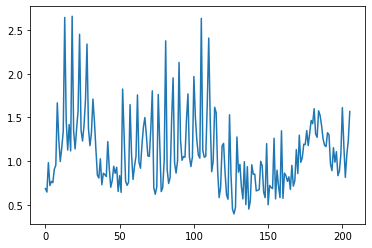

In [141]:
plt.plot(rho_full_3d_2[0])

In [114]:
y = train_pd['label_binary'].values

In [142]:
X_train_rho, X_vali_rho, y_train_rho, y_vali_rho = train_test_split(rho_full_3d_2, y, test_size = 0.25, random_state = 666)

**data is in the right shape. now lets invoke tensor board before we build the model and train**

In [122]:
from keras.callbacks import TensorBoard
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling1D, MaxPool1D, Dropout,Conv1D

In [161]:
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(206,1)))
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model1.add(Dropout(0.5))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(100, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [145]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 204, 64)           256       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 202, 64)           12352     
_________________________________________________________________
dropout_4 (Dropout)          (None, 202, 64)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 101, 64)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6464)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               646500    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [146]:
metrics1 = ['accuracy','TruePositives', 'TrueNegatives','FalsePositives','FalseNegatives','Precision','Recall']

In [162]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics1)

In [148]:
batch_size=32

In [163]:
tensorboard = TensorBoard(log_dir='./logs3', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True)
model1_hist = model1.fit(X_train_rho, y_train_rho, batch_size=batch_size, epochs=300, 
          validation_data = (X_vali_rho,y_vali_rho), callbacks = [tensorboard])

Epoch 1/300
4/4 [==============================] - 1s 214ms/step - loss: 0.6876 - accuracy: 0.7647 - true_positives: 0.0000e+00 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6089 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 20ms/step - loss: 0.5782 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6457 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
4/4 [==============================

4/4 [==============================] - 0s 38ms/step - loss: 0.0249 - accuracy: 0.9902 - true_positives: 22.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9565 - val_loss: 0.2419 - val_accuracy: 0.8571 - val_true_positives: 7.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 4.0000 - val_precision: 0.8750 - val_recall: 0.6364
Epoch 36/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0208 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2280 - val_accuracy: 0.8857 - val_true_positives: 8.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 3.0000 - val_precision: 0.8889 - val_recall: 0.7273
Epoch 37/300
4/4 [==============================] - 0s 44ms/step - loss: 0.0173 - accuracy: 1.0000 - true_pos

Epoch 53/300
4/4 [==============================] - 0s 37ms/step - loss: 0.0050 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2078 - val_accuracy: 0.9143 - val_true_positives: 8.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 3.0000 - val_precision: 1.0000 - val_recall: 0.7273
Epoch 54/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0039 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1916 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 55/300
4/4 [==============================] - 0s 39ms/step - loss: 0.0038 - ac

Epoch 71/300
4/4 [==============================] - 0s 38ms/step - loss: 0.0018 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1694 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 72/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0018 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1885 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 73/300
4/4 [==============================] - 0s 41ms/step - loss: 0.0014 - accura

Epoch 89/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0010 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1788 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 90/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0011 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1759 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 91/300
4/4 [==============================] - 0s 37ms/step - loss: 0.0011 - accuracy: 

Epoch 107/300
4/4 [==============================] - 0s 39ms/step - loss: 4.9437e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1595 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 108/300
4/4 [==============================] - 0s 16ms/step - loss: 7.4244e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1592 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 109/300
4/4 [==============================] - 0s 38ms/step - loss: 6.9550e-

Epoch 125/300
4/4 [==============================] - 0s 39ms/step - loss: 6.2460e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2052 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 126/300
4/4 [==============================] - 0s 16ms/step - loss: 7.7824e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1830 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 127/300
4/4 [==============================] - 0s 42ms/step - loss: 

Epoch 143/300
4/4 [==============================] - 0s 47ms/step - loss: 3.4825e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2048 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 144/300
4/4 [==============================] - 0s 21ms/step - loss: 4.2429e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1852 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 145/300
4/4 [==============================] - 0s 45ms/step - loss: 

Epoch 161/300
4/4 [==============================] - 0s 47ms/step - loss: 1.6973e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1839 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 162/300
4/4 [==============================] - 0s 18ms/step - loss: 2.3347e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1987 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 163/300
4/4 [==============================] - 0s 44ms/step - loss: 

Epoch 179/300
4/4 [==============================] - 0s 45ms/step - loss: 1.3229e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1982 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 180/300
4/4 [==============================] - 0s 18ms/step - loss: 2.7597e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2001 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 181/300
4/4 [==============================] - 0s 49ms/step - loss: 

Epoch 197/300
4/4 [==============================] - 0s 45ms/step - loss: 2.0438e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1859 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 198/300
4/4 [==============================] - 0s 17ms/step - loss: 1.4269e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1887 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 199/300
4/4 [==============================] - 0s 41ms/step - loss: 

Epoch 215/300
4/4 [==============================] - 0s 50ms/step - loss: 1.2269e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1794 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 216/300
4/4 [==============================] - 0s 21ms/step - loss: 1.3950e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1876 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 217/300
4/4 [==============================] - 0s 51ms/step - loss: 

Epoch 233/300
4/4 [==============================] - 0s 55ms/step - loss: 1.1072e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1892 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 234/300
4/4 [==============================] - 0s 22ms/step - loss: 8.3142e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1966 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 235/300
4/4 [==============================] - 0s 53ms/step - loss: 

Epoch 251/300
4/4 [==============================] - 0s 50ms/step - loss: 8.5716e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1751 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 252/300
4/4 [==============================] - 0s 19ms/step - loss: 1.8227e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1769 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 253/300
4/4 [==============================] - 0s 50ms/step - loss: 

Epoch 269/300
4/4 [==============================] - 0s 51ms/step - loss: 1.0771e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1966 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 270/300
4/4 [==============================] - 0s 23ms/step - loss: 1.1212e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2032 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 271/300
4/4 [==============================] - 0s 53ms/step - loss: 

Epoch 287/300
4/4 [==============================] - 0s 54ms/step - loss: 8.8955e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1735 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 288/300
4/4 [==============================] - 0s 24ms/step - loss: 9.2660e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1751 - val_accuracy: 0.9429 - val_true_positives: 9.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_precision: 1.0000 - val_recall: 0.8182
Epoch 289/300
4/4 [==============================] - 0s 50ms/step - loss: 

What proportion of actual positives was identified correctly?  RECALL

In [168]:
def lr_plot(history_obj,model_name):
    ''' input : model , model_name : tf model, str'''
    history = history_obj.history
    x_arr = np.arange(len(history['loss']))+1
    fig = plt.figure(figsize=(12,4))
    ax= fig.add_subplot(1,2,1)
    ax.plot(x_arr,history['loss'],'-',label='train')
    ax.plot(x_arr,history['val_loss'],'-',label='validation')
    ax.legend()
    ax.set_xlabel('Epoch',size=15)
    ax.set_ylabel('Loss',size=15)

    ax = fig.add_subplot(1,2,2)
    ax.plot(x_arr,history['recall'],'-',label='train')
    ax.plot(x_arr,history['val_recall'],'-',label='val')
    ax.legend()
    ax.set_xlabel('Epochs',size=15)
    ax.set_ylabel('Recall',size=15)
    fig.suptitle(model_name,fontsize='16')
    #plt.savefig('../images/lr_plot_model1_100epochs.png')
  

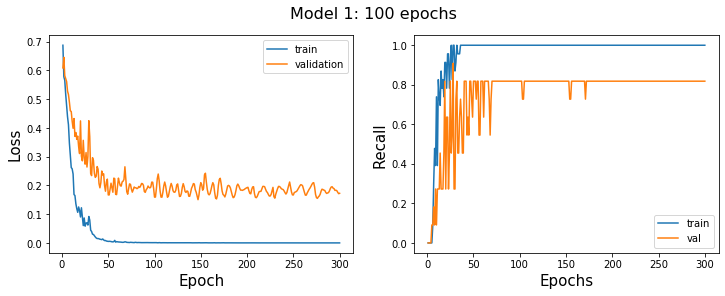

In [169]:
lr_plot(model1_hist,'Model 1: 100 epochs')

what to do next:

find that paper that did this and compair there architecture see iof i should deepen or something<br>
confusion matrix<br>
fix up slides and read me to find story flow?<br>
should i do a featurinzed clustering?<br>
